# PPOL 567 Final Project Code
## Eric LaRose
## May 6, 2021

This file contains all the code for the PPOL 567 final project, built around a text narrative that roughly parallels the PDF report document.

First, let's load the libraries we need and set up our Spark session.

## Loading in and Examining Data

In [1]:
# Set up Spark session
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [2]:
# Build an application
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("final_project").getOrCreate()

Next, let's load in the entire dataset using the code provided in the instructions for reading in a JSON file.

In [3]:
# Load in the entire dataset, which should have 476,259,744 rows
json_lzo = sc.newAPIHadoopFile("s3://bigdatateaching/reddit/lzo/", "com.hadoop.mapreduce.LzoTextInputFormat", "org.apache.hadoop.io.LongWritable", "org.apache.hadoop.io.Text")
# Look at first 10 rows
json_lzo.take(10)

# Use the commented out line below to instead load in only the sample data with 1 million rows
#json_lzo = sc.newAPIHadoopFile("s3://bigdatateaching/reddit/sample-data/1m-line-sample.json.lzo", "com.hadoop.mapreduce.LzoTextInputFormat", "org.apache.hadoop.io.LongWritable", "org.apache.hadoop.io.Text")


[(0,
  '{"archived":false,"author":"TistedLogic","author_created_utc":1312615878,"author_flair_background_color":null,"author_flair_css_class":null,"author_flair_richtext":[],"author_flair_template_id":null,"author_flair_text":null,"author_flair_text_color":null,"author_flair_type":"text","author_fullname":"t2_5mk6v","author_patreon_flair":false,"body":"Is it still r\\/BoneAppleTea worthy if it\'s the opposite?","can_gild":true,"can_mod_post":false,"collapsed":false,"collapsed_reason":null,"controversiality":0,"created_utc":1538352000,"distinguished":null,"edited":false,"gilded":0,"gildings":{"gid_1":0,"gid_2":0,"gid_3":0},"id":"e6xucdd","is_submitter":false,"link_id":"t3_9ka1hp","no_follow":true,"parent_id":"t1_e6xu13x","permalink":"\\/r\\/Unexpected\\/comments\\/9ka1hp\\/jesus_fking_woah\\/e6xucdd\\/","removal_reason":null,"retrieved_on":1539714091,"score":2,"send_replies":true,"stickied":false,"subreddit":"Unexpected","subreddit_id":"t5_2w67q","subreddit_name_prefixed":"r\\/Unexpect

We can see that this file is still in a JSON format, not at all suitable for a row/column structure. Next, let's use the code provided by Landry in the discussion forum on Canvas to convert this to a structured dataset where we can easily analyze rows and columns.

In [4]:
# Obtaining the schema from the data sample
data = spark.read.json("s3://bigdatateaching/reddit/sample-data/1m-line-sample.json")
schema = data.schema.json()
from pyspark.sql.types import *
from pyspark.sql.functions import col
import json
new_schema = StructType.fromJson(json.loads(schema))
new_schema

# map the schema into the raw dataset
from pyspark.sql import Row 
import pyspark.sql.functions as F

# This data object is a Spark DataFrame
reddit_comments_data_DF = json_lzo.map(lambda x:Row(x[1]))\
.toDF(['raw'])\
.select(F.from_json('raw',new_schema).alias('json')).select('json.*')


Next, let's look at the schema of the data and the number of total rows.

In [5]:
# Let's look at the Schema of this data
print(reddit_comments_data_DF.printSchema())

# Additionally, let's look at the number of rows
print("Number of comments is ", reddit_comments_data_DF.count())

root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_created_utc: long (nullable = true)
 |-- author_flair_background_color: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- a: string (nullable = true)
 |    |    |-- e: string (nullable = true)
 |    |    |-- t: string (nullable = true)
 |    |    |-- u: string (nullable = true)
 |-- author_flair_template_id: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-

We can see that there are 476,259,744 rows, or comments, in the dataset. Now that we have seen the schema above, next, let's look at the first 10 rows of the data to get a better idea of what the data looks like.

In [6]:
# Look at first 10 rows of the data
reddit_comments_data_DF.take(10)

[Row(archived=False, author='TistedLogic', author_cakeday=None, author_created_utc=1312615878, author_flair_background_color=None, author_flair_css_class=None, author_flair_richtext=[], author_flair_template_id=None, author_flair_text=None, author_flair_text_color=None, author_flair_type='text', author_fullname='t2_5mk6v', author_patreon_flair=False, body="Is it still r/BoneAppleTea worthy if it's the opposite?", can_gild=True, can_mod_post=False, collapsed=False, collapsed_reason=None, controversiality=0, created_utc=1538352000, distinguished=None, edited='false', gilded=0, gildings=Row(gid_1=0, gid_2=0, gid_3=0), id='e6xucdd', is_submitter=False, link_id='t3_9ka1hp', no_follow=True, parent_id='t1_e6xu13x', permalink='/r/Unexpected/comments/9ka1hp/jesus_fking_woah/e6xucdd/', removal_reason=None, retrieved_on=1539714091, score=2, send_replies=True, stickied=False, subreddit='Unexpected', subreddit_id='t5_2w67q', subreddit_name_prefixed='r/Unexpected', subreddit_type='public'),
 Row(arc

From the output above, we can see that this table contains a lot of information, much of which is probably of little interest to us. For instance, there are several variables that are essentially just "ID" variables, either of the post or the author. There are several variables that seem to correspond to author characteristics, which we also are probably not interested in. 

When looking at a Reddit post (on Reddit's website), some of the key components are the text of the post itself, the "score" or number of upvotes, and the subreddit it's posted on. First, let's look at the body of the post itself, as that is the "meat" of this dataset.

In [7]:
# Show the actual text of the first twenty Reddit comments in the dataset.
reddit_comments_data_DF.select("body").take(20)

[Row(body="Is it still r/BoneAppleTea worthy if it's the opposite?"),
 Row(body="I've tried and it's hit and miss. When it's good I feel more rested even though I've not slept well but sometimes it doesn't work"),
 Row(body="Hey that's great, I mean it. \n\nIn the other progress pic comment section there was a Redditor who talked about posting his own progress pic six months ago and mentioned he'd already put it back on and was dieting again.\n\nI'm not saying this to be an asshole, but the reality is that the vast majority of people who get healthy end up putting the weight back on. Do some research and find out what a healthy relationship with food looks like (if you haven't already). \n\nAs good as you feel now (and you've earned it), you'll feel equally as depressed if you wind up taking another ride on the rolly-polly-coaster. \n\nFind some healthy recipes, pick up an active hobby, maybe grow your own veggie garden and you'll find out junk food doesn't actually taste all that good

We can see the actual text of the first 20 comments! But there are immediately several issues apparent (which would be apparent in just about any text analysis dataset). First, there is punctuation and capitalization, etc., which we want to eliminate so that, for instance, "We" and "we" are not treated as separate words. Second, there are several comments that contain non-English words - there appears to be one comment in French, and there is also a URL provided in one post. We will want to remove rows corresponding to these comments. Additionally, there are several comments that have no substantial content (they are only one or two words, or they appear to have been removed). Furthermore, there are lots of very frequently used "stop words" (such as "the", "and", etc.) which we will want to remove before performing any analysis because otherwise these will bias any calculations of similarity. Finally, we will likely want to remove comments that contain only a handful of words. We clean up the text below.

## Cleaning up "Body" Column Containing Text

First, we remove capitalization and punctuation below.

In [8]:
# First, define a function that removes punctuation from a string and converts
# all text to lowercase
def convert_to_lowercase_remove_punctuation(input_string):
    # Define a list of punctuation that we want to remove
    punctuation_to_remove = '.,!?/"#$&\'()*+,-:;<=>@%[\\]^_`{|}~'
    # Remove all punctuation from the string
    for punctuation_mark in punctuation_to_remove:
        input_string = input_string.replace(punctuation_mark, '')
    # Convert the string to lowercase
    input_string = input_string.lower()
    # Finally, remove any extra whitespace at the beginning or end
    intput_string = input_string.strip()
    # Remove any extra whitespace within the text (possibly accounting for 2-5 spaces)
    input_string = input_string.replace('     ', ' ')
    input_string = input_string.replace('    ', ' ')
    input_string = input_string.replace('   ', ' ')
    input_string = input_string.replace('  ', ' ')

    # Return the cleaned string
    return input_string

# Need this to apply user-defined functions in Spark
from pyspark.sql.functions import udf
# Specify above function as a UDF 
udf_remove_punc = udf(convert_to_lowercase_remove_punctuation)
# Apply this function to "body" column
reddit_comments_data_DF = reddit_comments_data_DF.withColumn("cleaned_body", udf_remove_punc("body")) 

# Compare "body" and "cleaned_body" columns to make sure function worked!
reddit_comments_data_DF.select("body", "cleaned_body").take(5)


[Row(body="Is it still r/BoneAppleTea worthy if it's the opposite?", cleaned_body='is it still rboneappletea worthy if its the opposite'),
 Row(body="I've tried and it's hit and miss. When it's good I feel more rested even though I've not slept well but sometimes it doesn't work", cleaned_body='ive tried and its hit and miss when its good i feel more rested even though ive not slept well but sometimes it doesnt work'),
 Row(body="Hey that's great, I mean it. \n\nIn the other progress pic comment section there was a Redditor who talked about posting his own progress pic six months ago and mentioned he'd already put it back on and was dieting again.\n\nI'm not saying this to be an asshole, but the reality is that the vast majority of people who get healthy end up putting the weight back on. Do some research and find out what a healthy relationship with food looks like (if you haven't already). \n\nAs good as you feel now (and you've earned it), you'll feel equally as depressed if you win

We can see that we have successfully removed punctuation and capitalization! Next, we want to tokenize the body, or convert it to an array of words (rather than one long string, as it currently is), before performing any further analysis. 

In [9]:
# Import some functions needed for tokenizing and removing stop words
from pyspark.ml.feature import StopWordsRemover, Tokenizer

# First, tokenize text (convert it to array of words)
reddit_tokenizer = Tokenizer(inputCol='cleaned_body', outputCol='tokenized_body')
reddit_comments_data_DF = reddit_tokenizer.transform(reddit_comments_data_DF)

# Compare columns to make sure function worked!
reddit_comments_data_DF.select("body", "cleaned_body", "tokenized_body").take(5)

[Row(body="Is it still r/BoneAppleTea worthy if it's the opposite?", cleaned_body='is it still rboneappletea worthy if its the opposite', tokenized_body=['is', 'it', 'still', 'rboneappletea', 'worthy', 'if', 'its', 'the', 'opposite']),
 Row(body="I've tried and it's hit and miss. When it's good I feel more rested even though I've not slept well but sometimes it doesn't work", cleaned_body='ive tried and its hit and miss when its good i feel more rested even though ive not slept well but sometimes it doesnt work', tokenized_body=['ive', 'tried', 'and', 'its', 'hit', 'and', 'miss', 'when', 'its', 'good', 'i', 'feel', 'more', 'rested', 'even', 'though', 'ive', 'not', 'slept', 'well', 'but', 'sometimes', 'it', 'doesnt', 'work']),
 Row(body="Hey that's great, I mean it. \n\nIn the other progress pic comment section there was a Redditor who talked about posting his own progress pic six months ago and mentioned he'd already put it back on and was dieting again.\n\nI'm not saying this to be an

Next, let's remove some common stop words (such as "the", "and", and so on).


In [10]:
# Apply stop words remover to remove stop words from our text
SW_remover = StopWordsRemover(inputCol='tokenized_body', outputCol='body_SW_removed')
reddit_comments_data_DF = SW_remover.transform(reddit_comments_data_DF)

# Compare columns to make sure function worked!
reddit_comments_data_DF.select("tokenized_body", "body_SW_removed").take(5)

[Row(tokenized_body=['is', 'it', 'still', 'rboneappletea', 'worthy', 'if', 'its', 'the', 'opposite'], body_SW_removed=['still', 'rboneappletea', 'worthy', 'opposite']),
 Row(tokenized_body=['ive', 'tried', 'and', 'its', 'hit', 'and', 'miss', 'when', 'its', 'good', 'i', 'feel', 'more', 'rested', 'even', 'though', 'ive', 'not', 'slept', 'well', 'but', 'sometimes', 'it', 'doesnt', 'work'], body_SW_removed=['ive', 'tried', 'hit', 'miss', 'good', 'feel', 'rested', 'even', 'though', 'ive', 'slept', 'well', 'sometimes', 'doesnt', 'work']),
 Row(tokenized_body=['hey', 'thats', 'great', 'i', 'mean', 'it', '', '', 'in', 'the', 'other', 'progress', 'pic', 'comment', 'section', 'there', 'was', 'a', 'redditor', 'who', 'talked', 'about', 'posting', 'his', 'own', 'progress', 'pic', 'six', 'months', 'ago', 'and', 'mentioned', 'hed', 'already', 'put', 'it', 'back', 'on', 'and', 'was', 'dieting', 'again', '', 'im', 'not', 'saying', 'this', 'to', 'be', 'an', 'asshole', 'but', 'the', 'reality', 'is', 'tha

Next, we want to identify and remove comments that are not in English. We use the `nltk` package which has a list of over 200,000 words that compose the English corpus. We can then identify and remove words that are not in this corpus.

In [11]:
# Download the English corpus and look at the number of words in the corpus
import nltk
nltk.download('words')
English_words = set(nltk.corpus.words.words())
print("Number of words in English corpus is ", len(English_words))

Number of words in English corpus is  235892


[nltk_data] Downloading package words to /home/hadoop/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [12]:
# Define a function to remove words not in English corpus
# This function assumes the input is a list of strings
def remove_non_English_words(list_of_strings):
    # Create a new blank list
    new_list = []
    # Loop over each string and if the word is in the English corpus, add it to the new list
    for word in list_of_strings:
        if word in English_words:
            new_list.append(word)

    return new_list

# Specify above function as a UDF 
udf_remove_non_English = udf(remove_non_English_words, ArrayType(StringType()))
# Apply this function to "body" column
reddit_comments_data_DF = reddit_comments_data_DF.withColumn("final_cleaned_body", udf_remove_non_English("body_SW_removed"))

# Compare pre-cleaning and final cleaned text columns to make sure everything has worked!
reddit_comments_data_DF.select("body", "final_cleaned_body").take(5)


[Row(body="Is it still r/BoneAppleTea worthy if it's the opposite?", final_cleaned_body=['still', 'worthy', 'opposite']),
 Row(body="I've tried and it's hit and miss. When it's good I feel more rested even though I've not slept well but sometimes it doesn't work", final_cleaned_body=['tried', 'hit', 'miss', 'good', 'feel', 'even', 'though', 'slept', 'well', 'sometimes', 'doesnt', 'work']),
 Row(body="Hey that's great, I mean it. \n\nIn the other progress pic comment section there was a Redditor who talked about posting his own progress pic six months ago and mentioned he'd already put it back on and was dieting again.\n\nI'm not saying this to be an asshole, but the reality is that the vast majority of people who get healthy end up putting the weight back on. Do some research and find out what a healthy relationship with food looks like (if you haven't already). \n\nAs good as you feel now (and you've earned it), you'll feel equally as depressed if you wind up taking another ride on th

We can see that we have successfully removed non-English words, including some URLs and some words that appear to be French. Next, we want to calculate the number of words in each post (excluding words that we've removed, so that we are calculating the  number of "meaningful" words). There are two reasons for this. One is that we probably want to remove very short posts, which are not likely to have any meaningful content. Another is that the length of each post may be an interesting variable in its own right that we want to use for future analysis.

In [13]:
# Define a function to return the length of a list, i.e. the number of words in the post
# Using LongType instead of IntegerType because it is easier to work with filtering later on
calc_num_of_words = udf(lambda given_list: len(given_list), LongType())
# Apply this function to produce a new column with number of words in each post
reddit_comments_data_DF = reddit_comments_data_DF.withColumn("post_number_of_words", calc_num_of_words("final_cleaned_body")) 
# Check that this worked
reddit_comments_data_DF.select("final_cleaned_body", "post_number_of_words").take(10)

[Row(final_cleaned_body=['still', 'worthy', 'opposite'], post_number_of_words=3),
 Row(final_cleaned_body=['tried', 'hit', 'miss', 'good', 'feel', 'even', 'though', 'slept', 'well', 'sometimes', 'doesnt', 'work'], post_number_of_words=12),
 Row(final_cleaned_body=['hey', 'thats', 'great', 'mean', 'progress', 'pic', 'comment', 'section', 'posting', 'progress', 'pic', 'six', 'ago', 'already', 'put', 'back', 'saying', 'reality', 'vast', 'majority', 'people', 'get', 'healthy', 'end', 'weight', 'back', 'research', 'find', 'healthy', 'relationship', 'food', 'like', 'havent', 'already', 'good', 'feel', 'youve', 'feel', 'equally', 'depressed', 'wind', 'taking', 'another', 'ride', 'find', 'healthy', 'pick', 'active', 'hobby', 'maybe', 'grow', 'garden', 'find', 'junk', 'food', 'doesnt', 'actually', 'taste', 'good', 'give', 'break', 'alright'], post_number_of_words=62),
 Row(final_cleaned_body=['guy', 'gun', 'ran', 'like', 'really', 'fast', 'stopped', 'think', 'help', 'like', 'sprint', 'sure', 'r

From the above text, we can see that posts with a very small number of words don't seem to convey any meaningful information. As a good rule, it seems that posts with at least around 10 words seem to have meaningful information. The exact number is somewhat arbitrary, but from a visual inspection it does appear that comments with below about 10 words generally don't seem to convey a meaningful sentence or "story". Let's filter the dataset to only contain posts with at least 10 words, and then look at the number of rows remaining.

In [14]:
# Keep only rows corresponding to posts with at least 10 words
reddit_comments_data_DF_cleaned = reddit_comments_data_DF.filter("post_number_of_words > 9")
# Look at summary statistics and number of rows remaining
reddit_comments_data_DF_cleaned.select('post_number_of_words').describe().show()

+-------+--------------------+
|summary|post_number_of_words|
+-------+--------------------+
|  count|           139657973|
|   mean|  26.360449625027854|
| stddev|  27.976356594019126|
|    min|                  10|
|    max|                4786|
+-------+--------------------+



We can see that by only keeping rows with at least 10 meaningful words, we have 139,657,973 rows remaining, meaning that we have removed approximately 70.7 percent of our data. 

## Looking at and Cleaning Other Columns

Before we move to more aggregate exploratory data analysis, let's turn to some of the other columns. First, as noted above most of the columns appear to contain information that is generally irrelevant, such as ID numbers and so forth. Thus, below we keep only the following columns that appear to contain potentially useful information: the original body text ("body"), the cleaned body text ("final_cleaned_body"), the number of words in the cleaned body ("post_number_of_words"), whether a post is controversial ("controversiality" - according to Reddit, a controversial post is one that appears to have a high number of both upvotes and downvotes), the time of the post ("created_utc"), the score ("score"), and the subreddit name ("subreddit"). 

Once we select only these columns, we write this back to a Parquet file and read it back in, which makes some subsequent operations much easier.

In [15]:
# Keep only the columns we need, as specified above
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.select("body", "final_cleaned_body", "post_number_of_words", 
                                                                        "controversiality", "created_utc", "score", "subreddit")

# Write this file to Parquet and then read it back in - this makes much of the subsequent cleaning we do run much 
# faster as the Parquet file type is column-based 
reddit_comments_data_DF_cleaned.write.parquet("s3://ericlarosefinalprojectbucket/reddit_comments_data_DF_not_fully_cleaned.parquet",mode="overwrite")
# Read file back in
reddit_comments_data_DF_cleaned = spark.read.parquet("s3://ericlarosefinalprojectbucket/reddit_comments_data_DF_not_fully_cleaned.parquet")

# Look at first 5 rows of this dataframe
reddit_comments_data_DF_cleaned.take(5)

[Row(body='Your post was removed from /r/iamverysmart because it contains information that could be used to identify the user. Please refer to Rule 1 for further information.\n\nIf you believe your post was removed by error, please message the moderators.', final_cleaned_body=['post', 'removed', 'information', 'used', 'identify', 'user', 'please', 'refer', 'rule', 'information', 'believe', 'post', 'removed', 'error', 'please', 'message'], post_number_of_words=16, controversiality=0, created_utc=1540410116, score=1, subreddit='iamverysmart'),
 Row(body='* Username: /u/rabbitfire102\n* Join date: 2017-01-22 11:22:48\n* Link karma: 525\n* Comment karma: 167\n* Reputation: 362 trade(s)\n* Heatware: [http://www.heatware.com/u/109733](http://www.heatware.com/u/109733)\n\n^^This ^^information ^^does ^^not ^^guarantee ^^a ^^successful ^^swap. ^^It ^^is ^^being ^^provided ^^to ^^help ^^potential ^^trade ^^partners ^^have ^^more ^^immediate ^^background ^^information ^^about ^^with ^^whom ^^they

This seems to be a much easier dataset to work with than what we had initially. Next, let's look at summary statistics of our quantitative variables - "post_number_of_words," "score", and "controversiality". (The last of those variables is technically a qualitative dummy variable but it is still useful to look at summary statistics of this variable.)

In [16]:
# Describe numeric columns (controversiality is technically a qualitative dummy variable)
reddit_comments_data_DF_cleaned.select("post_number_of_words", "score", "controversiality").describe().show()

+-------+--------------------+------------------+-------------------+
|summary|post_number_of_words|             score|   controversiality|
+-------+--------------------+------------------+-------------------+
|  count|           139657973|         139657973|          139657973|
|   mean|  26.360449625027854|10.171745296632652|0.02657823910991462|
| stddev|  27.976356594019084| 169.2174968114663|0.16084724586073035|
|    min|                  10|            -22280|                  0|
|    max|                4786|             90192|                  1|
+-------+--------------------+------------------+-------------------+



From the output above, we can see that there do not appear to be any missing values of these three variables. "controversiality" is a (qualitative) dummy variable equal to 1 if a post is controversial, 0 otherwise. The mean indicates that only about 2.66% of posts are flagged as "controversial". The minimum and maximum values of "post_number_of_words" and "score" show that these variables are likely to be highly right-tail skewed, but we will look at this in more detail later. Note that you can indeed have a negative score on a Reddit post, so negative values are not "wrong" or incorrect values.

Before doing further analysis of quantitative variables, it is obvious that our "created_utc" variable, which indicates the time of the post, needs to be converted to an actual time that is understandable by humans. In theory this should contain the year, month, day, hour, minute, and so on of the post. In practice we are probably not going to be interested in any analysis of the day, hour, or minute, because there are so many possible values. At the same time, from the project instructions we know that all the data is only from two possible years, so we probably won't be interested in the year. What we are going to be most interested in is the month of the post. A month is a long-enough time horizon for news cycles or other trends to play out, and there are enough months (4) in our dataset to potentially see some interesting variation. Below, let's extract the month of the data.

In [17]:
# This date is in what's known as Unix time, measuring the number of seconds since the start of 1970.
# We can use the time package to extract the month and year from this dataset
import time
# Define a function that extracts the month from each post 
extract_month = udf(lambda given_Unix_time: time.strftime("%m", time.localtime(int(given_Unix_time))))
# Apply this function to produce a new column with month of each post
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.withColumn("month", extract_month("created_utc").cast(LongType())) 

# Check that this successfully worked
reddit_comments_data_DF_cleaned.select("created_utc", "month").show(20)

+-----------+-----+
|created_utc|month|
+-----------+-----+
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029463|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
| 1541029464|   10|
+-----------+-----+
only showing top 20 rows



We can see that we have successfully created a month column. Looking back at the dataset, it does not appear that there are any obvious transformations left to be done. Before we look at general patterns in the data and more aggregate EDA, though, let's first look at the distribution of the "score" and "post_number_of_words" to assess factors like skew or outliers.

In [18]:
# Look at summary statistics of scores by first getting the number of comments with each score
hist_of_scores = reddit_comments_data_DF_cleaned.groupBy('score').count().toPandas()
# Look at most frequent counts
print(hist_of_scores.sort_values('count', ascending = False).head(10))
# Look at the number of comments with negative scores
print("Number of comments with negative scores:")
print(hist_of_scores[hist_of_scores['score'] < 0]['count'].sum())
# Look at the number of comments with scores between -100 and 100
print("Number of comments with scores between -100 and 100, inclusive:")
print(hist_of_scores[(hist_of_scores['score'] <= 100) & (hist_of_scores['score'] >= -100)]['count'].sum())

# Additionally, summarize the score variable in the original cleaned document
print("Summary statistics of score variable")
print(reddit_comments_data_DF_cleaned.select('score').summary().show())

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


       score     count
5526       1  50335383
10265      2  24270457
8541       3  13323596
11237      4   5801185
5455       5   5443188
367        0   4831082
3607       6   4062030
860        7   3105198
9273       8   2456188
3935       9   1989265
Number of comments with negative scores:
5715217
Number of comments with scores between -100 and 100, inclusive:
138177713
Summary statistics of score variable
+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|         139657973|
|   mean|10.171745296632652|
| stddev|169.21749681146628|
|    min|            -22280|
|    25%|                 1|
|    50%|                 2|
|    75%|                 5|
|    max|             90192|
+-------+------------------+

None


We can see that the most frequently occurring scores tend to be the lowest positive values, which is what we would probably expect. The table of summary statistics indicates that scores tend to be highly right-tail skewed, since the average of roughly 10.17 is far greater than the median of 2. The table also shows that at least three-quarters of comments have scores of 5 or less. On the other hand, only about 4 percent of comments seem to have negative scrores. At the same time, there are definitely extreme outliers, including at least one comment with a score of over 90,000. In many instances, you would simply want to log a variable that is right-tail skewed to make it resemble a more normal distribution. However, comments can have negative scores which makes that impossible in this case without removing or otherwise adjusting negative scores. It is highly likely, however, that comments with negative scores differ in important ways from comments with postive scores (they may have more words with negative connotations, for instance), so we do not simply want to remove them even though the above output shows that less than 5% of comments have negative scores. One way to eliminate the skew is to keep only numbers within a certain range. As an arbitrary value, let's consider comments that have a score between -100 and 100, inclusive. Let's look at the distribution when we only keep scores in this range.

In [19]:
# Look at summary statistics of comments with scores between -100 and 100
print(reddit_comments_data_DF_cleaned.filter((reddit_comments_data_DF_cleaned.score >= -100) & (reddit_comments_data_DF_cleaned.score <= 100)).select('score').summary().show())


+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|         138177713|
|   mean| 4.763946889177418|
| stddev|10.347059027073419|
|    min|              -100|
|    25%|                 1|
|    50%|                 2|
|    75%|                 4|
|    max|               100|
+-------+------------------+

None


We can see that the skew appears to be largely eliminated as the median is a lot closer to the mean and the mean is now only slightly above the 75th percentile. Additionally, since we have capped the score value at 100 we have guaranteed that there are no extreme outliers. Furthermore, by looking at the counts we can see that we have still retained over 98 percent of all observations. Thus, in the full dataset let's remove comments with a score outside of the range $[-100, 100]$, which we can see before still retains over 98% of all values. 

In [20]:
# From the full dataset of comments, remove rows with scores outside the range [-100, 100]
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.filter("score >= -100 and score <= 100")


Next, let's turn to the "post_number_of_words" variable, which indicates the number of words in the comment (calculated AFTER removing stop words, punctuation, non-English words, etc.). We repeat the same process to look at summary statistics of this variable below. Also, remember that we have already left-truncated this variable to only include comments with at least ten words.

In [21]:
# Look at summary statistics of word counts
hist_of_word_counts = reddit_comments_data_DF_cleaned.groupBy('post_number_of_words').count().toPandas()
# Look at most frequent counts
print("Most frequent word counts:")
print(hist_of_word_counts.sort_values('count', ascending = False).head(10))
# Look at the number of comments with fewer than 250 words
print("Number of comments with fewer than 250 words:")
print(hist_of_word_counts[hist_of_word_counts['post_number_of_words'] <= 250]['count'].sum())

# Additionally, summarize the word count variable in the original cleaned document
print("Summary statistics of post_number_of_words variable")
print(reddit_comments_data_DF_cleaned.select('post_number_of_words').summary().show())

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


Most frequent word counts:
      post_number_of_words     count
453                     10  12446654
718                     11  10863823
662                     12   9502640
854                     13   8372791
905                     14   7453984
961                     15   6969148
1125                    16   5987082
334                     17   5429268
886                     18   4867768
22                      19   4387957
Number of comments with fewer than 250 words:
137905434
Summary statistics of post_number_of_words variable
+-------+--------------------+
|summary|post_number_of_words|
+-------+--------------------+
|  count|           138177713|
|   mean|  26.364043715211874|
| stddev|  27.944210495108695|
|    min|                  10|
|    25%|                  13|
|    50%|                  18|
|    75%|                  29|
|    max|                4786|
+-------+--------------------+

None


We can see that the majority of posts are quite short, with at least 75% of posts being 29 or fewer words. Additionally, the ten most common word counts are exactly the values between 10 and 19, which provides further evidence that most comments are quite short. However, the mean is over 26 words compared to a median of 18, which indicates a right-tail skew, while the maximum of 4,786 indicates that there are some extreme outliers. Let's try investigating what happens when we consider posts with 90 words or fewer (so that the midpoint of our range is 50 words). 

In [22]:
# Look at summary statistics of number of words when we consider posts between 10 and 90 words, inclusive
# Note that we only need to include one condition because we have already filtered out posts with fewer than 10 words
reddit_comments_data_DF_cleaned.filter("post_number_of_words < 91").select('post_number_of_words').summary("count", "mean", "stddev", "25%", "50%", "75%").show()


+-------+--------------------+
|summary|post_number_of_words|
+-------+--------------------+
|  count|           134434464|
|   mean|  23.054639047022942|
| stddev|  15.095583924326265|
|    25%|                  13|
|    50%|                  18|
|    75%|                  28|
+-------+--------------------+



We can see that limiting posts to 90 words keeps over 95% of observations and the mean length is now much closer to the median length, and well below the 75th percentile. There still appears to be some skew, but much less than before and we have eliminated extreme outliers while retaining the vast majority of observations. Let's formally filter this data.

In [23]:
# Filter data to only include rows (comments) with between 10 and 90 words, inclusive
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.filter("post_number_of_words < 91")

We note that in our filtered data, there are now 134,434,464 observations remaining. Now that we have cleaned our numerical data, let's do a quick check to make sure there are no missing values in our dataframe. If there are, we need to come up with a way of dealing with missing observations.

In [24]:
# Assess for missingness (both null and NaN values) in the dataset (for all variables excluding the string columns)
reddit_comments_data_DF_cleaned.select([F.count(F.when(F.col(variable).isNull() | F.isnan(variable), variable)).alias(variable) for variable in reddit_comments_data_DF_cleaned.columns[2:]]).show()


+--------------------+----------------+-----------+-----+---------+-----+
|post_number_of_words|controversiality|created_utc|score|subreddit|month|
+--------------------+----------------+-----------+-----+---------+-----+
|                   0|               0|          0|    0|        0|    0|
+--------------------+----------------+-----------+-----+---------+-----+



We can see that there are no missing values. A final method of exploration is to look at the actual words that appear in the text. The chunk of code below calculates the number of times each word appears in the dataset and displays the most frequent words.

In [25]:
# Count the number of times each word appears in the data, and then show the most 20 common words
print("20 most common words in the Reddit comments data:")
print(reddit_comments_data_DF_cleaned.withColumn('word', F.explode(F.col('final_cleaned_body'))).groupBy('word').count().sort('count', ascending=False).show())

# Additionally, print the total nubmer of words in the dataset
print("Total number of unique words in the Reddit comments data:")
print(reddit_comments_data_DF_cleaned.withColumn('word', F.explode(F.col('final_cleaned_body'))).groupBy('word').count().toPandas().shape[0])

# Create a Pandas dataframe out of the word counts
word_counts = reddit_comments_data_DF_cleaned.withColumn('word', F.explode(F.col('final_cleaned_body'))).groupBy('word').count().sort('count', ascending=False).toPandas()


20 most common words in the Reddit comments data:
+------+--------+
|  word|   count|
+------+--------+
|  like|38125852|
|   get|26124383|
|   one|24602601|
|people|24555883|
|  dont|22713948|
| think|19764906|
|  time|18216909|
|really|16311427|
|  also|16120497|
|  good|15647301|
|  even|15541379|
|  know|15317737|
|  make|14339107|
|please|13400434|
|  much|13229587|
|  want|12660003|
|   see|12634616|
|   way|11992676|
| still|11879438|
|  game|11668940|
+------+--------+
only showing top 20 rows

None
Total number of unique words in the Reddit comments data:


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


111941


We can see that there is a very clear problem here. Namely, the 20 most common words are all very commonly used words, such as "like", "one", "really", and "also", that probably have no predictive power in a machine learning algorithm. While we have already removed "stop words" and addressed other common issues in text data, it is still difficult to fully remove speech that might be extraneous for our given analysis. Typically in machine learning algorithms with text data, you create a dummy variable equal to 1 if a given word is in a document, and 0 otherwise. In this case, we would clearly want to pick words that are common enough to appear in more than just a handful of documents, but not common enough that they appear in a large share of document. In other words, maximum predictive power should come from words that are "somewhat" frequent. 

Additionally, we can see that there are 111,941 unique words appearing in this data (even after removing stop words!), which is an impractical number of words to include in a machine learning algorithm. To address both of these issues, let's pick a random list of 1,000 words that have a count equal to between 0.25 and 1 percent of the total rows in the data. For reference, the most frequent word "like" has a count equal to 25 percent of the total number of comments. Thus, we expect that words words with a count between 0.25 and 1 percent of the total number of comments should be "somewhat frequent."

In [26]:
# Get num rows in data
num_rows_in_data = reddit_comments_data_DF_cleaned.count()

# Get a list of possible word choices as those where the total word count is between 0.1 and 1 percent of the total rows in the data
possible_word_choices = word_counts[(word_counts['count'] > (0.0025 * num_rows_in_data)) & (word_counts['count'] < (0.01 * num_rows_in_data))]

# Randomly select 1000 words from this list, setting seed for reproducibility
actual_word_choices = possible_word_choices.sample(n = 1000, axis = 0, random_state = 236)

In [27]:
# Show the head of the data
actual_word_choices.head(20)

,word,count
890,learned,655218
480,simple,1216301
695,meet,841239
1514,description,347104
1097,threshold,513770
503,health,1169740
443,giving,1318206
1017,block,559193
1517,consistent,346698
1256,excuse,439235


The results of this look great! It appears that these words are specific enough to convey some kind of special meaning, but not so specific so as to only appear in a handful of documents. The words "campaign" and "learned", for instance, clearly convey a lot more meaning than "like" or "really." Because we have chosen 1,000 words which appear with roughly 0.25 to 1 percent frequency in comments ("roughly" because the same word can be repeated in a comment), in theory most comments should contain at least one word that appears here. Next, let's write a function that creates a new variable which contains, for each post, a list of those words that appear in the above dataframe. 

In [28]:
# Convert 1,000 chosen words to a list
list_of_word_choices = list(actual_word_choices['word'])

# Define a function to remove words which do not appear in the list of 1,000 randomly selected words above
# This function assumes the input is a list of strings
def keep_selected_words(list_of_strings):
    # Create a new blank list
    new_list = []
    # Loop over each string and if the word is in the list_of_word_choices, add it to the new list
    for word in list_of_strings:
        if word in list_of_word_choices:
            new_list.append(word)

    return new_list

# Specify above function as a UDF 
udf_keep_selected_words = udf(keep_selected_words, ArrayType(StringType()))
# Apply this function to "body" column
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.withColumn("chosen_words", udf_keep_selected_words("final_cleaned_body"))

# Compare before and after columns to make sure everything has worked!
reddit_comments_data_DF_cleaned.select("final_cleaned_body", "chosen_words").take(20)


[Row(final_cleaned_body=['post', 'removed', 'information', 'used', 'identify', 'user', 'please', 'refer', 'rule', 'information', 'believe', 'post', 'removed', 'error', 'please', 'message'], chosen_words=['user', 'refer', 'error']),
 Row(final_cleaned_body=['join', 'date', 'link', 'karma', 'comment', 'karma', 'reputation', 'information', 'guarantee', 'successful', 'swap', 'provided', 'help', 'potential', 'trade', 'immediate', 'background', 'information', 'swapping', 'please', 'sure', 'familiarize'], chosen_words=['join', 'date', 'successful', 'provided', 'potential', 'familiarize']),
 Row(final_cleaned_body=['whether', 'work', 'really', 'cause', 'v', 'pain', 'tight', 'nerve', 'yes', 'probably', 'help', 'sure', 'give', 'plenty', 'time', 'quite', 'bit', 'consistent', 'couple', 'home', 'also', 'use', 'wand', 'internal', 'trigger', 'point', 'relief', 'ton', 'flare', 'far', 'yoga', 'happy', 'help', 'give', 'advice', 'want', 'teach', 'yoga', 'give', 'help', 'pelvic', 'floor', 'good', 'luck'],

Now it appears that we are in pretty good shape for more aggregate exploratory data analysis. Let's first keep only columns that we need and then save to a Parquet file and read it back in. Finally, we will display the number of rows of our final cleaned dataset.

In [29]:
# Keep only columns we need for the remainder of this analysis.
reddit_comments_data_DF_cleaned = reddit_comments_data_DF_cleaned.select('final_cleaned_body', 'chosen_words', 'post_number_of_words', 'controversiality', 'score', 'subreddit', 'month')
# Show first 5 rows of this DF
reddit_comments_data_DF_cleaned.take(5)


[Row(final_cleaned_body=['post', 'removed', 'information', 'used', 'identify', 'user', 'please', 'refer', 'rule', 'information', 'believe', 'post', 'removed', 'error', 'please', 'message'], chosen_words=['user', 'refer', 'error'], post_number_of_words=16, controversiality=0, score=1, subreddit='iamverysmart', month=10),
 Row(final_cleaned_body=['join', 'date', 'link', 'karma', 'comment', 'karma', 'reputation', 'information', 'guarantee', 'successful', 'swap', 'provided', 'help', 'potential', 'trade', 'immediate', 'background', 'information', 'swapping', 'please', 'sure', 'familiarize'], chosen_words=['join', 'date', 'successful', 'provided', 'potential', 'familiarize'], post_number_of_words=22, controversiality=0, score=1, subreddit='mechmarket', month=10),
 Row(final_cleaned_body=['whether', 'work', 'really', 'cause', 'v', 'pain', 'tight', 'nerve', 'yes', 'probably', 'help', 'sure', 'give', 'plenty', 'time', 'quite', 'bit', 'consistent', 'couple', 'home', 'also', 'use', 'wand', 'inter

In [30]:
# Save this as a Parquet file
reddit_comments_data_DF_cleaned.write.parquet("s3://ericlarosefinalprojectbucket/reddit_comments_data_DF_cleaned.parquet",mode="overwrite")

In [31]:
# Read this Parquet file back in 
reddit_comments_data_DF_cleaned = spark.read.parquet("s3://ericlarosefinalprojectbucket/reddit_comments_data_DF_cleaned.parquet")

In [32]:
# Check that this data loaded back in correctly and confirm count of observations.
reddit_comments_data_DF_cleaned.count()

134434464

We can see that our final cleaned dataset has 134,434,464 rows, compared to 476,259,744 in the original dataset. Thus, after our cleaning we have kept roughly 28.2% of the original observations.  

## Aggregate Exploratory Data Analysis

Previously, we have done analysis of individual variables, one at a time, in order to clean the data. Now we turn to aggregate data analysis, aggregating variables by groups in various ways and looking at the relationship between variables. To facilitate this analysis, let's first make a SQL table from our data, which lends to some efficient exploratory data analysis (EDA) operations.

In [33]:
# Create a SQL table of cleaned reddit data
reddit_comments_data_DF_cleaned.createOrReplaceTempView("reddit_comments_SQL")

# Look at the first 5 rows of our data
spark.sql("""
SELECT * 
FROM reddit_comments_SQL
LIMIT 5
""").cache().show()

+--------------------+--------------------+--------------------+----------------+-----+--------------+-----+
|  final_cleaned_body|        chosen_words|post_number_of_words|controversiality|score|     subreddit|month|
+--------------------+--------------------+--------------------+----------------+-----+--------------+-----+
|[yes, drunk, edit...|[drunk, method, w...|                  24|               0|    2|instant_regret|    1|
|[hard, part, wint...|[winter, term, de...|                  16|               0|   22|    TeachingUK|    1|
|[please, please, ...|               [sad]|                  18|               0|    1|  iamverysmart|    1|
|[bring, thats, co...|[bring, comfortab...|                  11|               0|    2|           nfl|    1|
|[throw, ball, gam...|[throw, ball, any...|                  11|               0|    1|        ravens|    1|
+--------------------+--------------------+--------------------+----------------+-----+--------------+-----+



A first method of exploration is to look at the relationship between the length of each comment and the score. It might be reasonable to assume that longer comments have higher scores, on average. For instance, if a Redditor posts a question, a longer comment will likely be seen as more informative and helpful, thus receiving a higher score. Below, we calculate the average score among each post length and plot the relationship to see if one exists.

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


Correlation of score and number of words across all comments:
-0.01040361291637522


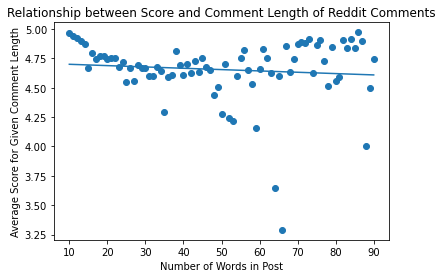

In [34]:
# Calculate average score conditional on number of words in each post
average_score_per_length = spark.sql("""
SELECT post_number_of_words, AVG(score)
FROM reddit_comments_SQL
GROUP BY post_number_of_words
ORDER BY post_number_of_words
""").cache().toPandas()

# Create a plot of average score against number of words
import matplotlib.pyplot as plt
import numpy as np
# Add the actual data points
plt.scatter(average_score_per_length['post_number_of_words'], average_score_per_length['avg(score)'])
# Add a best fit linear regression line
m, b = np.polyfit(average_score_per_length['post_number_of_words'], average_score_per_length['avg(score)'], 1)
plt.plot(average_score_per_length['post_number_of_words'], m*average_score_per_length['post_number_of_words'] + b)
plt.xlabel('Number of Words in Post')
plt.ylabel('Average Score for Given Comment Length')
plt.title('Relationship between Score and Comment Length of Reddit Comments')

# Print the correlation of the two variables
print("Correlation of score and number of words across all comments:")
print(reddit_comments_data_DF_cleaned.stat.corr('post_number_of_words', 'score'))

From above, we can see that there appears to be a slightly negative relationship between the length of the post and the average score. Perhaps Redditors don't enjoy reading really long comments and tend to downvote them. That said, the relationship is quite weak, and there appear to be some drastic ups and downs from one number to the next in the right half of the plot. Additionally, the expected score goes from about 4.7 for a 10-word post to 4.6 for a 90-word one, which is only a 2-3% decrease. Overall, the relationship appears to be quite weak and probably not super interesting to explore in further detail.

Next, let's look at the number of comments and the average score and comment length by month, to see if there any interesting patterns over time.

In [35]:
# Look at number of comments, average score, and average word length by month
spark.sql("""
SELECT month, COUNT(*) as num_comments_in_month, AVG(score) as avg_score_in_month, AVG(post_number_of_words) as avg_word_count_in_month
FROM reddit_comments_SQL
GROUP BY month
ORDER BY month
""").cache().show()

+-----+---------------------+------------------+-----------------------+
|month|num_comments_in_month|avg_score_in_month|avg_word_count_in_month|
+-----+---------------------+------------------+-----------------------+
|    1|             36984346| 4.728388572830245|     23.191880910912957|
|   10|             32492916|  4.73210163716916|     22.983557246754955|
|   11|             31983857| 4.806779526309163|     23.030853877316922|
|   12|             32973345| 4.788317745742812|       22.9938200992347|
+-----+---------------------+------------------+-----------------------+



We can see that there are substantially more posts in January 2019 than October, November, or December of 2018. Perhaps there were certain events that gained a lot of attention on Reddit in January. However, the average score and average word count appear very similar across all months, and the total number of comments is very similar across October, November, and December 2018. Overall, it does not seem like there are any drastic variations in characteristics of comments across months.

Next, let's turn to subreddits - namely, what are the most popular subreddits and how does the average score and word count vary across subreddits? Additionally, how many subreddits are there in this data? We use a SQL query below to investigate this.

In [36]:
# Find number of subreddits in the data
spark.sql("""
SELECT COUNT(DISTINCT subreddit) 
FROM reddit_comments_SQL
""").cache().show()

+-------------------------+
|count(DISTINCT subreddit)|
+-------------------------+
|                   117324|
+-------------------------+



In [37]:
# Find 20 most popular subreddits, and average score and word count and proportion of controversial posts
spark.sql("""
SELECT subreddit, COUNT(*) as num_comments_in_subreddit, AVG(score) as avg_score_in_subreddit, AVG(post_number_of_words) as avg_word_count_in_subreddit, 100 * AVG(controversiality) as pct_controv_in_subreddit
FROM reddit_comments_SQL
GROUP BY subreddit
ORDER BY num_comments_in_subreddit DESC
LIMIT 20
""").cache().show(20)

+-------------------+-------------------------+----------------------+---------------------------+------------------------+
|          subreddit|num_comments_in_subreddit|avg_score_in_subreddit|avg_word_count_in_subreddit|pct_controv_in_subreddit|
+-------------------+-------------------------+----------------------+---------------------------+------------------------+
|          AskReddit|                  7020471|     4.394678077866855|         23.329451115174468|      1.3601793953710513|
|           politics|                  3089379|     5.579538476826572|         22.818860359962308|       4.324946858252096|
|          worldnews|                  1309005|     4.425363539482278|          24.07224189365205|       7.909442668286218|
|                nfl|                  1010022|     6.119587494133791|           18.8510854219017|       4.215452732712753|
|               news|                  1004261|     5.477906639807779|          23.39685201357018|        9.26870604354844|
|   unpo

From above, we can see that there are 117,324 distinct subreddits but the large majority of comments are clearly in a small number of subreddits. The top 5 subreddits alone appear to contain roughly about 10% of all Reddit comments. The most popular subreddits appear to be on fairly varied topics, ranging from Q&A forums to political forums to news to sports to humor and other topics. It is also apparent that there is quite a bit of variation in the average score, word count, and controversiality of each subreddit. For instance, we can see that over 9% of posts in the "news" subreddit are controversial, compared with only 1.36 percent in the "AskReddit" subreddit. Likewise, the "The_Donald" subreddit has an average score of 7.92 while the "FortNiteBR" subreddit has an average score of just 2.86. Similar large differences exist for the average word count. For instance, the "CFB" ("college football") subreddit has an average post length of around 19 words compared to nearly 27 words for "relationship_advice." This also makes sense because comments in the latter subreddit presumably give advice, which probably requires more than a small number of words. On the other hand, the former subreddit is probably more likely to contain short comments that say in around 10-15 words, "go team!"

To investigate this dispersion further, let's visualize these average for all subreddits with at least 100 posts (a somewhat artbitrary number, but large enough so that one post won't substantially skew averages).

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


   subreddit  num_comments_in_subreddit  avg_score_in_subreddit  \
0  AskReddit                    7020471                4.394678   
1   politics                    3089379                5.579538   
2  worldnews                    1309005                4.425364   
3        nfl                    1010022                6.119587   
4       news                    1004261                5.477907   

   avg_word_count_in_subreddit  pct_controversial_in_subreddit  
0                    23.329451                        1.360179  
1                    22.818860                        4.324947  
2                    24.072242                        7.909443  
3                    18.851085                        4.215453  
4                    23.396852                        9.268706  


Text(0.5, 1.0, 'Average Scores and Comments by Subreddit among those with at Least 100 Posts ')

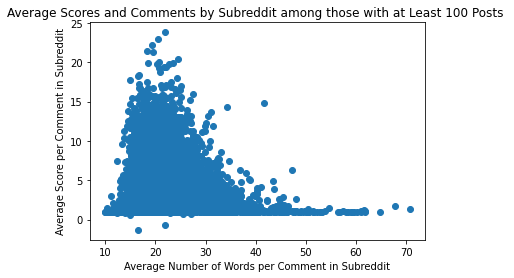

In [38]:
# Among subreddits with at least 100 posts, create a Pandas dataframe of the subreddit 
subreddits_at_least_100_posts = spark.sql("""
SELECT subreddit, COUNT(*) as num_comments_in_subreddit, AVG(score) as avg_score_in_subreddit, AVG(post_number_of_words) as avg_word_count_in_subreddit, 100 * AVG(controversiality) as pct_controversial_in_subreddit
FROM reddit_comments_SQL
GROUP BY subreddit
HAVING num_comments_in_subreddit >= 100
ORDER BY num_comments_in_subreddit DESC
""").cache().toPandas()
# Print first 5 rows of this dataframe
print(subreddits_at_least_100_posts.head(n=5))

# Plot average word count and score by subreddit
# Add the actual data points
plt.scatter(subreddits_at_least_100_posts['avg_word_count_in_subreddit'], subreddits_at_least_100_posts['avg_score_in_subreddit'])
plt.xlabel('Average Number of Words per Comment in Subreddit')
plt.ylabel('Average Score per Comment in Subreddit')
plt.title('Average Scores and Comments by Subreddit among those with at Least 100 Posts ')


Text(0.5, 1.0, 'Average Scores and Controversiality by Subreddit among those with at Least 100 Posts ')

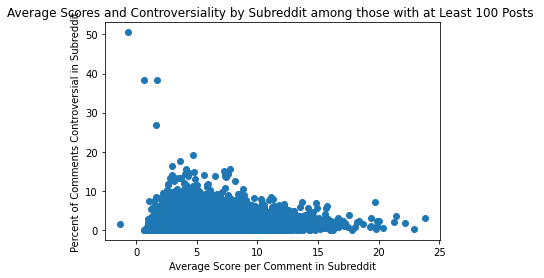

In [39]:
# Plot average score and percent controversial by subreddit
plt.scatter(subreddits_at_least_100_posts['avg_score_in_subreddit'], subreddits_at_least_100_posts['pct_controversial_in_subreddit'])
plt.xlabel('Average Score per Comment in Subreddit')
plt.ylabel('Percent of Comments Controversial in Subreddit')
plt.title('Average Scores and Controversiality by Subreddit among those with at Least 100 Posts ')


The plots above show that there isn't an obviously strong correlation of these subreddit-level variables with each other. It looks like on average, the average score tends to decrease slightly with the average comment length, but it looks like a small effect and for the subreddits that have an average word count close to the average word count among all subreddits, there is a ton of variation in scores. Likewise, it appears that the percent of comments marked as controversial appears to decrease slightly with the average score of the subreddit, but again there is very wide variation of these variables within subreddits. That is, the average word count, score, and controversiality can substantially change between subreddits, and knowing which subreddit a comment is in may give you a better ability to guess the comment's characteristics.

Now that we've shown that the subreddits tend to have some different characteristics, let's look in more detail at the "controversiality" variable. Reddit appears to label a post as "controversial" if it has received a large number of both upvotes and downvotes. Thus, we might reasonable expect that controversial posts tend to have a score close to 0, as do non-controversial posts, but that the disperion of scores among controversial posts will be considerably lower. Let's look at some summary statistics using a SQL query below.

In [40]:
# Look at average score and word length among controversial and non-controversial posts
spark.sql("""
SELECT COUNT(*) as total_num_comments, AVG(score) as avg_score, AVG(post_number_of_words) as avg_word_count
FROM reddit_comments_SQL
GROUP BY controversiality
""").cache().show()

# Additionally, calculate the total number of comments that are controversial
spark.sql("""
SELECT 100*AVG(controversiality) AS pct_controversial
FROM reddit_comments_SQL
""").cache().show()

+------------------+------------------+-----------------+
|total_num_comments|         avg_score|   avg_word_count|
+------------------+------------------+-----------------+
|         130808925|4.8800555543132855|23.05358946264561|
|           3625539|0.5261344589039036|23.09250790020463|
+------------------+------------------+-----------------+

+------------------+
| pct_controversial|
+------------------+
|2.6968821030892793|
+------------------+



First, we can see that only 2.6% of comments are classified as controversial. Additionally, the average word count is extremely similar among controversial and non-controversial posts but the average score appears considerably lower among controversial posts. Let's use some box-and-whisker plots to visualize this below, using a random sample of 100,000 rows of the dataset. 

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


array([<AxesSubplot:title={'center':'post_number_of_words'}, xlabel='controversiality'>,
       <AxesSubplot:title={'center':'score'}, xlabel='controversiality'>],
      dtype=object)

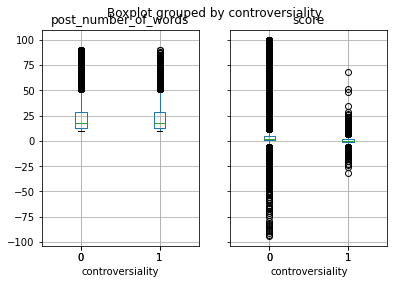

In [41]:
# Take a random sample of 100,000 rows from the data
num_rows = reddit_comments_data_DF_cleaned.count()
boxplot_data = reddit_comments_data_DF_cleaned.select('controversiality', 'post_number_of_words', 'score').sample(withReplacement = False, fraction = 100000/num_rows, seed = 6832).toPandas()

# Do box and whisker plot of scores and number of words, grouped by controversiality score
boxplot_data.boxplot(column=["post_number_of_words", "score"], by="controversiality")



We can clearly see that the distributions of the number of words look very similar among controversial and non-controversial posts. However, the distribution of scores looks quite different. Particularly, the range of scores is much lower among controversial comments, with no very low and very few very high scores among controversial posts.

When we looked at individual subreddits, we also saw that controversiality varied a lot among subreddits. It seems that knowing a post's subreddit and its total score can potentially give you some strong predictive power in guessing whether or not a post is controversial.

Next, let's look at the most common words in controversial and non-controversial posts to see if there are clear differences in factors such as tone. Particularly, **among the 1,000 chosen words determined earlier**, we calculate the word counts among controversial and non-controversial posts and see if there are any clear differences in the most and least frequent of these words.

In [42]:
# Calculate word counts among controversial posts
word_counts_controversial = reddit_comments_data_DF_cleaned.filter("controversiality = 1").withColumn('word', F.explode(F.col('chosen_words'))).groupBy('word').count().sort('count', ascending=False).toPandas()
# Display most common words in controversial posts, among 1,000 chosen words
print("20 most common chosen words in controversial posts:")
print(word_counts_controversial.head(20))
# Display least common words in controversial posts, among 1,000 chosen words
print("10 least common chosen words in controversial posts:")
print(word_counts_controversial.tail(10))


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


20 most common chosen words in controversial posts:
         word  count
0   political  62822
1      racist  61251
2    argument  60668
3       woman  57242
4     clearly  56999
5       media  56095
6      public  53970
7        news  53605
8       human  52753
9         gun  52650
10   shouldnt  52554
11         en  51649
12  seriously  51308
13        law  50937
14       poor  50445
15   majority  49056
16      child  48157
17       fair  47689
18      funny  45670
19          e  45564
10 least common chosen words in controversial posts:
            word  count
990       filter   3900
991        flair   3774
992        audio   3575
993        hello   3359
994       adjust   3259
995    moderator   2659
996       repost   2195
997    threshold   1653
998     resubmit    225
999  familiarize    188


In [43]:
# Calculate word counts among non-controversial posts
word_counts_non_controversial = reddit_comments_data_DF_cleaned.filter("controversiality = 0").withColumn('word', F.explode(F.col('chosen_words'))).groupBy('word').count().sort('count', ascending=False).toPandas()
# Display most common words in non-controversial posts, among 1,000 chosen words
print("20 most common chosen words in non-controversial posts:")
print(word_counts_non_controversial.head(20))
# Display least common words in non-controversial posts, among 1,000 chosen words
print("10 least common chosen words in non-controversial posts:")
print(word_counts_non_controversial.tail(10))


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


20 most common chosen words in non-controversial posts:
            word    count
0           text  1330828
1           mine  1323915
2        feeling  1320379
3         bought  1314342
4           book  1313612
5       specific  1309208
6        totally  1300330
7           shot  1297759
8   relationship  1297345
9        whether  1293093
10       quality  1291066
11         movie  1290618
12             e  1282441
13    discussion  1280566
14         front  1279031
15        giving  1275003
16           cut  1274570
17         along  1271636
18        advice  1269510
19         bring  1265750
10 least common chosen words in non-controversial posts:
        word   count
990     rent  329506
991  federal  328652
992    cross  328590
993    brown  328359
994  heavily  326750
995   former  326066
996   racism  326054
997   cancer  324632
998  western  324091
999   demand  322993


Wow! We can see that among the 1,000 randomly selected words to be used in this analysis, the most common words that appear in controversial posts indeed are words that sound controversial or have very negative connotations, including "political", "racist", "gun", "shouldnt", and "poor". In contrast, the most common words in non-controversial posts do indeed appear to be neutrally- or positively-charged. 

It seems that we have the grounds for some interesting modeling here. Namely, we have seen several factors that appear to be correlated with controversial comments, including the words used, the score, and the subreddit (as some subreddits have substantially higher rates of controversial posts than others). It seems that if we know the subreddit of a post, the words used (among the 1,000 randomly selected), and some other characteristics, we might be able to accurately model the likelihood of a given post being controversial. This is a classification problem as the outcome is binary. 

## Preparing Data for Modeling, and Conducting Modeling

In theory we want to set up our data so that our features are a set of 1,000 dummy variables indicating whether each of the 1,000 randomly selected words appears in a post, a set of dummy variables corresponding to the subreddit in which a post appears, and two numeric variables corresponding to the score and number of words of the comment. As we saw above, there are well over 100,000 subreddits, roughly as many as the number of unique words we found, so it would be completely infeasible to include a dummy variable for each subreddit. Additionally, a large number of subreddits have very few posts which could easily skew results. To greatly simplify things, we want to create a dataset where we consider only comments that have appeared in the 20 most popular subreddits. We create this dataset below, and use this in our modeling. 

In [44]:
# Create a subset of the data that only includes comments in the 20 most popular subreddits
# (Defined as the 20 subreddits with the highest number of total comments)
comments_top_20_subreddits = spark.sql("""
SELECT *
FROM reddit_comments_SQL
WHERE subreddit IN (SELECT subreddit
FROM reddit_comments_SQL
GROUP BY subreddit
ORDER BY COUNT(*) DESC
LIMIT 20)
""").cache()

# Show that this data retrieval was successful
print(comments_top_20_subreddits.take(10))

# Keep only comments that we need for the future array. Particularly, we can drop the "final_cleaned_body" variable as 
# we won't use the entire text in our modeling. Additionally, we can drop the month as we won't use this in our 
# analysis, because we did not observe any interesting patterns by month.
comments_top_20_subreddits = comments_top_20_subreddits.drop('final_cleaned_body', 'month')

# Check that columns were successfully dropped 
print("Check that columns were successfully dropped")
print(comments_top_20_subreddits.show(10))


[Row(final_cleaned_body=['even', 'dislike', 'hard', 'hate', 'game', 'done', 'pretty', 'damn', 'well', 'like', 'much', 'though', 'tilly', 'probably', 'favorite', 'girl', 'plus', 'like', 'name'], chosen_words=['damn', 'favorite', 'girl'], post_number_of_words=19, controversiality=0, score=16, subreddit='reddeadredemption', month=1), Row(final_cleaned_body=['hi', 'post', 'removed', 'body', 'text', 'box', 'use', 'title', 'field', 'post', 'question', 'per', 'rule', 'use', 'body', 'text', 'box', 'resubmit', 'post', 'opinion', 'whats', 'better', 'closeness', 'child', 'making', 'sure', 'better', 'life', 'without', 'bot', 'action', 'automatically', 'please', 'contact'], chosen_words=['hi', 'text', 'box', 'field', 'text', 'box', 'resubmit', 'child'], post_number_of_words=34, controversiality=0, score=1, subreddit='AskReddit', month=1), Row(final_cleaned_body=['dont', 'understand', 'tie', 'regulation', 'neither', 'team', 'well', 'enough', 'win', 'one', 'team', 'get', 'advantage', 'overtime'], cho

In [45]:
# Display number of rows that we are using in our modeling
print("Number of rows we are using in our modeling is: ")
print(comments_top_20_subreddits.count())


Number of rows we are using in our modeling is: 
23908294


In [46]:
# Write this result to a Parquet file and then read it back in 
comments_top_20_subreddits.write.parquet("s3://ericlarosefinalprojectbucket/comments_top_20_subreddits.parquet",mode="overwrite")
# Read raw data back in from S3 bucket
comments_top_20_subreddits = spark.read.parquet("s3://ericlarosefinalprojectbucket/comments_top_20_subreddits.parquet")

**We can see that in our final dataset that we use for modeling, we have 23,908,294 rows before splitting up the data into training, testing, and validation sets.**

Before proceeding with any modeling, we first want to split our data up into train, validation, and test datasets. The train dataset will be used to actually train the model. The validation dataset will be used for hyperparameter tuning in our models, which we will discuss in more detail below. After hyperparameter tuning, the test dataset will be used to evaluate the actual performance of the final model.

Below, we reserve 90% of the data for training, 5% for testing, and 5% for validation, and then look at the number of rows in each dataset.

In [47]:
# Split data into 90% for training, 5% for validation, and 5% for testing
splitted_data = comments_top_20_subreddits.randomSplit([0.9, 0.05, 0.05], seed = 19582)
# Get training, validation, and testing data
train_data = splitted_data[0]
validation_data = splitted_data[1]
test_data = splitted_data[2]

# Print number of rows in each dataset
print("Number of training records: " + str(train_data.count()))
print("Number of validation records: " + str(validation_data.count()))
print("Number of test records: " + str(test_data.count()))
comments_top_20_subreddits.show()

Number of training records: 21515698
Number of validation records: 1196099
Number of test records: 1196497
+--------------------+--------------------+----------------+-----+-------------------+
|        chosen_words|post_number_of_words|controversiality|score|          subreddit|
+--------------------+--------------------+----------------+-----+-------------------+
|[lie, simple, eve...|                  12|               0|   11|           politics|
|                  []|                  10|               0|    1|relationship_advice|
|[lots, lots, judg...|                  20|               0|    5|              funny|
|[crazy, covered, ...|                  19|               0|    1|                nfl|
|[older, sister, s...|                  45|               0|    1|      relationships|
|[biggest, land, p...|                  55|               0|    1|          AskReddit|
|[shot, mention, d...|                  13|               0|   15|                CFB|
|[solid, garbage, ...| 

**Above, we can see that we have 21,515,698 rows in our training data, 1,196,099 rows in our validation data, and 1,196,497 rows in our test data.**

Next, let's discuss the prediction models we use to predict whether a post is tagged as controversial or not. The motivation and possible use cases of these models are discussed in more detail in the main report. The models that we use here are regularized LASSO logistic regression and Bernoulli naive Bayes (NB). Both are frequently used to predict binary outcomes. A key advantage of regularized LASSO is that the regression model can discard variables it deems to be relatively important; since we have a large number of variables here, this is a useful feature as many are likely to be relatively unimportant. A key advantage of Bernoulli naive Bayes is that it works well with sparse data, which is what we have here (because for a given observation, the vast majority of feature values will be zero). Additionally, Bernoulli naive Bayes is specifically built to handle binary data, and all but two of our feature columns are binary (we have to drop these two feature columns when doing naive Bayes, but keep them when doing logistic regression). The disadvantages of the algorithms are discussed in more detail in the main report. Overall, some other models such as random forests were chosen because they do not perform well with very sparse data (discussed in more detail in the main report). In regularized LASSO regression, there is one hyperparameter $\lambda$ that we use to control the extent to which coefficients are "penalized." The higher the value of $\lambda$, the more variable coefficients we expect to become zero. In Bernoulli naive bayes, there is a smoothing parameter $\alpha$ which is meant to tackle the issue of producing an estimated zero probability in naive Bayes. (This is discussed in more detail in the main report.) In the code below, we use the validation set to look at different levels of accuracy as we vary $\lambda$ and $k$ in the respective models.

One important different between the two models is that naive Bayes will require only dummy variables, so we do not include the score or the number of words in the model. We drop these variables from the Bernoulli naive Bayes model but include them in the logistic regression model.

Before actually doing hyperparameter tuning, we need to prepare a Pipeline of the data transformations that we use in our model. In particular, regularized logistic regression requires that variables should be measured on the same scale. Almost all of our variables are dummy variables, which are obviously on a 0-1 scale. However, the "score" and "post_number_of_words" variables are clearly not on this scale but rather on a -100 to 100 and 10 to 90 scale, respectively. Thus, we use min-max scaling to transform both of these variables to a 0-1 scale. Min-max scaling means that a value of -100 of score, for instance, becomes 0, and a value of 100 becomes 1, while a score of 0 becomes 0.5 because it is halfway in between the minimum and maximum of the variable. Likewise, a score of 50 would become 0.75 when transformed under min-max scaling.

Additionally, we need to create a set of 1,000 dummy variables corresponding to our 1,000 chosen words, where each variable has  a value of 1 if the corresponding word appears in the comment, and 0 otherwise. Finally, we need to convert the subreddit string variable to a set of dummy variables, each corresponding to a value of 1 if the given comment appears in that subreddit, and 0 otherwise. Note that each comment can only have a value of 1 for one subreddit dummy variable, because comments cannot appear in multiple subreddits.

Our hypotheses and possible use cases are discussed in more detail in the main report. Overall, we have shown that common words appears to vary substantially between controversial and non-controversial posts, and there are important differences in scores among controversial and non-controversial posts. Additionally, some subreddits have much higher rates of controversial posts than others. Overall, we have seen evidence that a model incorporating these factors is thus likely to do well at predicting controversial posts.

The chunks of code below creates the basic pipeline necessary to transform all of the data.

In [48]:
# This section of code creates the pipeline necessary to transform variables appropriately
# First, conduct min-max scaling of score and post_number_of_words variables
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
# Note that we must convert each variable to a vector before we can apply the MinMaxScaler, 
# due to the properties of the MinMaxScalerclass 
# Score:
# Convert to vector
score_vector = VectorAssembler(inputCols = ["score"], outputCol = "score_vector")
# Then apply min-max scaler to the vector
score_scale = MinMaxScaler(inputCol="score_vector", outputCol="score_scaled", min = 0.0, max = 1.0)
# Number of words:
# Convert to vector
post_number_of_words_vector = VectorAssembler(inputCols = ["post_number_of_words"], outputCol = "post_number_of_words_vector")
# Then apply min-max scaler to the vector
post_number_of_words_scale = MinMaxScaler(inputCol = "post_number_of_words_vector", outputCol = "post_number_of_words_scaled", min = 0.0, max = 1.0)

# Next, use CountVectorizer to create a binary variable for each chosen word, creating 1,000 total dummy variables
from pyspark.ml.feature import CountVectorizer
# Minimum term and document frequencies of one guarantee that all of these 1,000 words will be kept.
chosen_words_vectorizer = CountVectorizer(inputCol = "chosen_words", outputCol = "chosen_words_vectorized", minDF = 1.0, minTF = 1.0, binary = True)

# Finally, convert subreddit variable to a set of categorical dummy variables
# First, use StringIndexer to convert a string to a single numeric variable
from pyspark.ml.feature import StringIndexer
subreddit_indexer = StringIndexer(inputCol = "subreddit", outputCol = "subreddit_index")
# Next, use OneHotEncoder to convert this numeric index to a set of dummy variables
from pyspark.ml.feature import OneHotEncoder 
subreddit_encoder = OneHotEncoder(inputCol = "subreddit_index", outputCol = "subreddit_encoded")


Now that we've done appropriate transformations to our feature data, we can define a feature vector. (Note that no transformations need to be made to our outcome variable as it is already in the form we need.)

In [49]:
# Define feature vector using the VectorAssembler method
# Note that in the logistic regression model, we include the score and the number of words
controv_model_features_logistic = VectorAssembler(
    inputCols=["score_scaled",
               "post_number_of_words_scaled",
               "chosen_words_vectorized",
               "subreddit_encoded"],
    outputCol="model_features")

# Because the Bernoulli naive Bayes model can only include binary variables, we drop the score and number of words 
# from the Naive Bayes model
controv_model_features_NB = VectorAssembler(
    inputCols=["chosen_words_vectorized",
               "subreddit_encoded"],
    outputCol="model_features")

We are just about ready to estimate out models! For the validation stage, we need to do hyperparameter tuning. Let's first do the hyperparameter tuning with regularized logistic regression (LASSO logistic regression). We will try a range of possible values of $\lambda$ that allows us to "hone in " on the correct value. The way we approach that is that for a given value of $\lambda$, we estimate the LASSO logistic regression model on the training set and then calculate the accuracy on the **validation set** (rather than the test set, which is only used to evaluate our final model).

In [50]:
# Specify a range of possible values of lambda
lambda_values = [0, 0.000001, 0.0001, 0.01, 0.05, 0.1]
# Create a blank list to which we append accuracy scores on our validation results
validation_accuracy_scores_for_lasso = []

In [51]:
# Import some packages we need
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml import Pipeline, Model
# Loop over our list of possible values of our hyperparameterr lambda
for lam in lambda_values:
    # Note that "elasticNetParam" is set to 0 to create a LASSO model, while "regParam" denotes lambda
    lasso_logistic_regression_model = LogisticRegression(maxIter=10, regParam=lam, elasticNetParam=0,
                                                         labelCol="controversiality", featuresCol="model_features")

    # Build the pipeline using the data manipulation steps and the logistic regression model with given value of lambda
    pipeline_logistic = Pipeline(stages=[score_vector, score_scale, post_number_of_words_vector, 
                                         post_number_of_words_scale, chosen_words_vectorizer,
                                         subreddit_indexer, subreddit_encoder, controv_model_features_logistic,
                                         lasso_logistic_regression_model])
        
    # Fit the logistic model on training data, then make predictions using validation data
    model_logistic = pipeline_logistic.fit(train_data)
    predictions = model_logistic.transform(validation_data)

    # Calculate accuracy from this model (defined as percent of correct predictions)
    evaluator_logistic = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_logistic.evaluate(predictions)

    # Calculate accuracy and append it to the blank list created above
    validation_accuracy_scores_for_lasso.append(accuracy)

Text(0.5, 1.0, 'Hyperparameter Tuning for LASSO Logistic Regression \n')

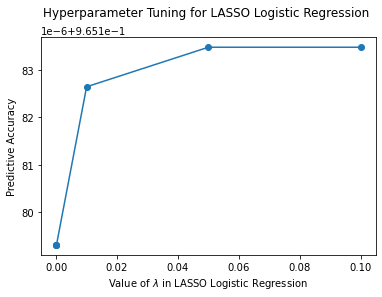

In [52]:
# Next, let's visualize these accuracy scores
plt.scatter(lambda_values, validation_accuracy_scores_for_lasso)
plt.plot(lambda_values, validation_accuracy_scores_for_lasso)
plt.xlabel('Value of $\lambda$ in LASSO Logistic Regression')
plt.ylabel('Predictive Accuracy')
plt.title('Hyperparameter Tuning for LASSO Logistic Regression \n')


Something interesting is happening here. We can see that for $\lambda$ not very close to 0, the predictive accuracy is the same regardless of the value of $\lambda$. The reason this is happening is that above a certain value of $\lambda$, the penalty applied is so large that all variable coefficients become zero. In other words, there really is no effective model, and the model is simply predicting that all posts are non-controversial. Let's confirm this by looking at the share of non-controversial posts in the validation data.

In [53]:
# Calculate percent of non-controversial posts in the validation data
print("Percent of non-controversial posts in validation data is " + str(1 - validation_data.agg({"controversiality": "avg"}).toPandas()['avg(controversiality)'][0]))


/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


Percent of non-controversial posts in validation data is 0.9651834839758248


We can see that the percent of non-controversial posts is exactly the same as the predictive accuracy for values of $\lambda$ not very close to zero. For lower values of $\lambda$, the model is actually less predictive; that is, when including some variables in our logistic regression, the model is less accurate than simply predicting that all posts are non-controversial! (Doing so guarantees 96.52% accuracy.) Thus, the "optimal" value of $\lambda$ is one that forces all variables to be zero. This behavior likely results from the highly imbalanced classes (in other words, controversial posts are a very small number of all posts). Looking at the results of this model isn't very interesting, though, so let's choose $\lambda = 0.0001$ which does yield a model with some non-zero variables even though it is less accurate than simply predicting all posts to be non-controversial.

Next, let's turn to tuning of the smoothing parameter in Bernoulli naive Bayes. The approach to do so is essentially exactly the same as we just did for logistic regression. This is done in the chunks of code below.

In [54]:
# Specify a range of possible values of alpha, the smoothing parameter
alpha_values = [0, 0.5, 1, 1.5, 2, 2.5, 3]
# Create a blank list to which we append accuracy scores on our validation results
validation_accuracy_scores_for_alpha = []

In [55]:
# Import package needed for Bernoulli naive Bayes
from pyspark.ml.classification import NaiveBayes

# Loop over our list of possible values of our hyperparameter alpha
for a in alpha_values:
    # Implement NaiveBayes model
    naive_bayes_model = NaiveBayes(modelType='bernoulli', smoothing = a,
                                   labelCol="controversiality", featuresCol="model_features")

    # Build the pipeline using the data manipulation steps and the naive Bayes model with given value of alpha
    # Note that this pipeline excludes the score and number of words variables.
    pipeline_NB = Pipeline(stages=[chosen_words_vectorizer, subreddit_indexer, subreddit_encoder, 
                                   controv_model_features_NB, naive_bayes_model])
        
    # Fit the naive Bayes model on training data, then make predictions using validation data
    model_NB = pipeline_NB.fit(train_data)
    predictions = model_NB.transform(validation_data)

    # Calculate accuracy from this model (defined as percent of correct predictions)
    evaluator_NB = MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator_NB.evaluate(predictions)

    # Calculate accuracy and append it to the blank list created above
    validation_accuracy_scores_for_alpha.append(accuracy)
    

Text(0.5, 1.0, 'Hyperparameter Tuning for Bernoulli Naive Bayes')

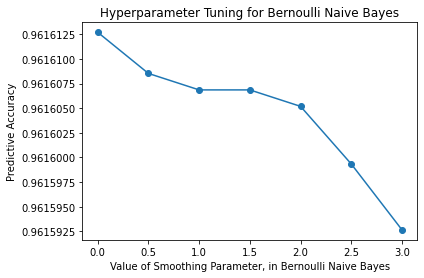

In [56]:
# Next, let's visualize these accuracy scores
plt.scatter(alpha_values, validation_accuracy_scores_for_alpha)
plt.plot(alpha_values, validation_accuracy_scores_for_alpha)
plt.xlabel('Value of Smoothing Parameter, in Bernoulli Naive Bayes')
plt.ylabel('Predictive Accuracy')
plt.title('Hyperparameter Tuning for Bernoulli Naive Bayes')


From the graph above it appears that for Gaussian Naive Bayes we should use a smoothing parameter of $0$ which gives the highest accuracy. Note that the accuracy score here is still less than simply predicting all posts to be non-controversial.

Next, we implement these models using the chosen hyperparameter values and evaluate them on the test data (rather than the validation data, which was used for hyperparameter tuning). First, let's implement the logistic regression model in the chunk of code below. 

In [57]:
# Note that "elasticNetParam" is set to 0 to create a LASSO model, while "regParam" denotes lambda
lasso_logistic_regression_model = LogisticRegression(maxIter=10, regParam=0.0001, elasticNetParam=0,
                                                     labelCol="controversiality", featuresCol="model_features")

# Build the pipeline using the data manipulation steps and the logistic regression model with given value of lambda
pipeline_logistic = Pipeline(stages=[score_vector, score_scale, post_number_of_words_vector, 
                                     post_number_of_words_scale, chosen_words_vectorizer,
                                     subreddit_indexer, subreddit_encoder, controv_model_features_logistic,
                                     lasso_logistic_regression_model])

# Fit the logistic model on training data, then make predictions using validation data
model_logistic = pipeline_logistic.fit(train_data)
predictions = model_logistic.transform(test_data)

# Calculate accuracy from this model (defined as percent of correct predictions)
# Print accuracy score:
print("Accuracy score for LASSO logistic regression model is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="accuracy").evaluate(predictions)))
# Print several other evaluation metrics: (weighted) recall, (weighted) precision, and F1 score
print("Recall (weighted) for LASSO logistic regression model is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)))
print("Precision (weighted) for LASSO logistic regression model is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)))
print("F1 score for LASSO logistic regression model is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="f1").evaluate(predictions)))


Accuracy score for LASSO logistic regression model is 0.9649861219877693
Recall (weighted) for LASSO logistic regression model is 0.9649861219877693
Precision (weighted) for LASSO logistic regression model is 0.9312029699804681
F1 score for LASSO logistic regression model is 0.9477935999011614


These numbers are discussed in more detail in the main report. To better understand them, let's construct a confusion matrix to look at the relatively frequency of false negatives and false positives. But to provide some context, let's look at the proprtion of non-controversial posts in the test data.

In [58]:
# Calculate percent of non-controversial posts in the test data
print("Percent of non-controversial posts in test data is " + str(1 - test_data.agg({"controversiality": "avg"}).toPandas()['avg(controversiality)'][0]))


Percent of non-controversial posts in test data is 0.9649886293070522


We can see that our LASSO logistic regression model is actually performing slightly worse than simply predicting all posts to be non-controversial. Let's look at the confusion matrix next:

Text(0.5, 1.0, 'Confusion Matrix for LASSO Logistic Regression')

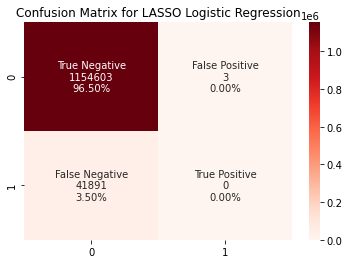

In [59]:
# This chunk of codes creates a confusion matrix
# First, get both the predictions and labels from the model
preds_and_labels = predictions.select(['prediction','controversiality']).withColumn('label', F.col('controversiality').cast(FloatType())).orderBy('prediction').select(['prediction','label'])

# Import package needed to get some classification metrics
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Import packages needed to represent a confusion matrix as a heatmap
import pandas as pd
import seaborn as sns
# Create confusion matrix
confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray())
# Create labels to be imposed on the heatmap, which will show what each cell 
# corresponds to, the number of observations in the cell, and the percent of
# observations in the cell.
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.to_numpy().flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.to_numpy().flatten()/np.sum(confusion_matrix.to_numpy())]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Create the heatmap and add a title
logistic_reg_plot = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Reds')
logistic_reg_plot.set_title('Confusion Matrix for LASSO Logistic Regression')


Wow! We can see that there wasn't a single post correctly flagged as controversial. Only 3 posts out of 1 million overall  were predicted as controversial, and none of those predicted as controversial actually were. This model is terrible at predicting which posts are controversial - in fact, it did not correctly predict a single post as controversial. We can see that among incorrect predictions, virtually 100% of them are false negatives instead of false positive. Our model isn't predicting **every** comment to be non-controversial, but it is coming extremely close to it.

Next, let's see if switching to a Bernoulli naive Bayes model improves our performance at all. This is done in the chunks of code below.

In [60]:
# Implement NaiveBayes model with alpha = 0, determined in hyperparameter tuning above
naive_bayes_model = NaiveBayes(modelType='bernoulli', smoothing = 0,
                               labelCol="controversiality", featuresCol="model_features")

# Build the pipeline using the data manipulation steps and the naive Bayes model with alpha = 0
# Note that this pipeline excludes the score and number of words variables.
pipeline_NB = Pipeline(stages=[chosen_words_vectorizer, subreddit_indexer, subreddit_encoder, 
                               controv_model_features_NB, naive_bayes_model])

# Fit the naive Bayes model on training data, then make predictions using test data
model_NB = pipeline_NB.fit(train_data)
predictions = model_NB.transform(test_data)

# Calculate accuracy from this model (defined as percent of correct predictions)
# and then print accuracy score:
print("Accuracy score for Bernoulli naive Bayes model is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="accuracy").evaluate(predictions)))
# Print several other evaluation metrics: (weighted) recall, (weighted) precision, and F1 score
print("Recall (weighted) for Bernoulli naive Bayes is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)))
print("Precision (weighted) for Bernoulli naive Bayes is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)))
print("F1 score for Bernoulli naive Bayes is " + str(MulticlassClassificationEvaluator(labelCol="controversiality", predictionCol="prediction", metricName="f1").evaluate(predictions)))


Accuracy score for Bernoulli naive Bayes model is 0.9614558164374838
Recall (weighted) for Bernoulli naive Bayes is 0.9614558164374838
Precision (weighted) for Bernoulli naive Bayes is 0.9346784245793783
F1 score for Bernoulli naive Bayes is 0.9467305671120113


These numbers are discussed in more detail in the main report, but overall we can see that the accuracy of naive Bayes is even lower than logistic regression. Both of these models appear to be quite bad at predicting which posts are controversial. Let's look at the confusion matrix below.

Text(0.5, 1.0, 'Confusion Matrix for Benoulli Naive Bayes')

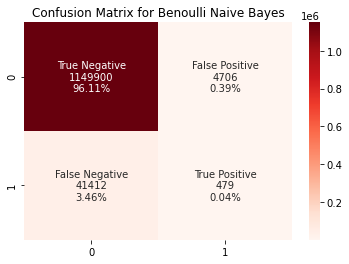

In [61]:
# This chunk of codes creates a confusion matrix, this time for the naive Bayes model
# First, get both the predictions and labels from the model
preds_and_labels = predictions.select(['prediction','controversiality']).withColumn('label', F.col('controversiality').cast(FloatType())).orderBy('prediction').select(['prediction','label'])

# Import package needed to get some classification metrics
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Import packages needed to represent a confusion matrix as a heatmap
import pandas as pd
import seaborn as sns
# Create confusion matrix
confusion_matrix = pd.DataFrame(metrics.confusionMatrix().toArray())
# Create labels to be imposed on the heatmap, which will show what each cell 
# corresponds to, the number of observations in the cell, and the percent of
# observations in the cell.
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.to_numpy().flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.to_numpy().flatten()/np.sum(confusion_matrix.to_numpy())]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Create the heatmap and add a title
logistic_reg_plot = sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Reds')
logistic_reg_plot.set_title('Confusion Matrix for Benoulli Naive Bayes')


We can see roughly the same pattern as in logistic regression. Both models very rarely predict controversial posts, although the naive Bayes model does so *much* more frequently than the logistic regression model - over 5000 posts are predicted as controversial, compared to 3 posts in the logistic regression model. Still, incorrect predictions are overwhelmingly false negatives - less than one-tenth of comments predicted as controversial actually are controversial. Both of these models appear to err on the side of classifying almost every observation as non-controversial, which seems understandable given the very small portion of overall comments that are classified as controversial. Shortcomings of these models, including possible paths for future work, are discussed in more detail in the main report. Otherwise, we close the Spark connection below and then this concludes this notebook.

In [62]:
# Close Spark connection and then we're done!
sc.stop()